In [1]:
import numpy as np
import pandas as pd

import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from bioframe.io.fileops import read_bigwig

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
from akita_utils.stats_utils import plot_map

In [3]:
genome_hic_cool = cooler.Cooler("/project/fudenber_735/backup/coolers/Krietenstein2019/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool")

In [4]:
genome_hic_name = "Krietenstein2019_HFF"

In [5]:
# defaults
pool_width = 1
diagonal_offset = 2
seq_len_nt = 1310720

In [6]:
padding = (640-512) // 2

In [7]:
chrom = "chr1"
start = 73787392
end = 75098112

# chrom = "chr9"
# start = 132259840
# end = 133570560

In [8]:
mseq_str = '%s:%d-%d' % (chrom, start, end)

In [9]:
mseq_str

'chr1:73787392-75098112'

In [10]:
seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

In [11]:
seq_hic_nan = np.isnan(seq_hic_raw)
num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))
if num_filtered_bins > (.5*len(seq_hic_nan)):
    print("WARNING: %s >50%% bins filtered, check:  %s. " % (genome_hic_file, mseq_str))

In [12]:
# clip first diagonals and high values
clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
for i in range(-diagonal_offset+1, diagonal_offset):
    set_diag(seq_hic_raw, clipval, i)
seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
seq_hic_raw[seq_hic_nan] = np.nan

In [13]:
# adaptively coarsegrain based on raw counts
seq_hic_smoothed = adaptive_coarsegrain(
                      seq_hic_raw,
                      genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                      cutoff=2, max_levels=8)
seq_hic_nan = np.isnan(seq_hic_smoothed)

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


In [14]:
# local obs/exp
seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]

In [15]:
log_hic_obsexp = np.log(seq_hic_obsexp)

In [16]:
log_hic_obsexp.shape

(640, 640)

In [17]:
# crop
if padding > 0:
  log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
  log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

In [18]:
kernel = Gaussian2DKernel(x_stddev=1.5)

In [19]:
kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)

In [20]:
np.nanmax(kernel_log_hic_obsexp), np.nanmin(kernel_log_hic_obsexp)

(1.211169580546799, -2.7632999728172556)

In [21]:
# np.savez(f'./matrices/{chrom}_{start}-{end}_map_tg0_target.npz', target=kernel_log_hic_obsexp)

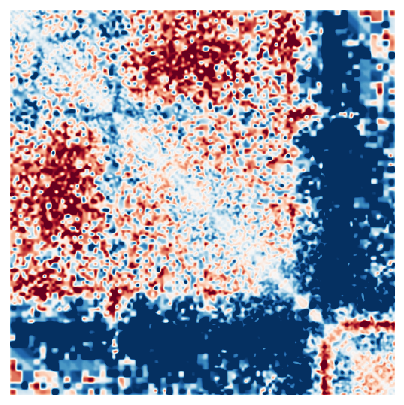

In [22]:
plot_map(kernel_log_hic_obsexp, vmin=-0.6, vmax=0.6)